In [1]:
import numpy as np      
import os# 開啟檔案

import torch
from torch import nn
from torch.utils import data
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchnet import meter

import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from linformer import Linformer


from IPython.display import clear_output

In [2]:
#mnist
transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.MNIST(root='./', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=transform)


split=0.8
train_size=int(len(train_set)*split)
traindata, valdata = data.random_split(train_set, [train_size, len(train_set)-train_size])

train_loader = data.DataLoader(traindata, batch_size=16, shuffle=True,num_workers=2)
valid_Loader = data.DataLoader(valdata, batch_size=16, shuffle=True,num_workers=2)
test_loader = data.DataLoader(test_set, batch_size=16, shuffle=True,num_workers=2)

In [3]:
class former(nn.Module):
    def __init__(self, dim, image_size, depth, heads, channels):
        super().__init__()
        self.seq_len=image_size**2
        
        self.in_embedding = nn.Linear(channels, dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, self.seq_len, dim))
        self.transformer=Linformer(   dim=dim,
                                      seq_len=self.seq_len,
                                      depth=depth,
                                      heads=heads,
                                      one_kv_head = True,
                                    share_kv = True)
        self.out_embedding= nn.Sequential( 
                                nn.LayerNorm(dim),
                                nn.Linear(dim, channels),
                                nn.Sigmoid())
    def forward(self,inputs):
        x = self.in_embedding(inputs)
        b, n, _ = x.shape
        x += self.pos_embedding[:, :n ]
        x = self.transformer(x)
        return self.out_embedding(x)



In [4]:
# Parameters
device ='cuda:0' if torch.cuda.is_available() else 'cpu'
print(device,'is available!\n')
model= former(dim=256,
              image_size=28,
              depth=6,
              heads=8,
              channels=1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model=model.to(device)
#print(model)

criterion  = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
scheduler=lr_scheduler.CosineAnnealingLR(optimizer,5)

cuda:0 is available!



ValidEpoch  1: 100%|█████████████████████████████████████████████████████| 750/750 [00:55<00:00, 13.61it/s, loss=0.141]


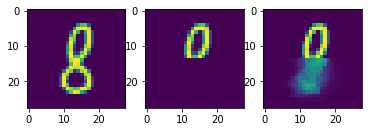

ValidEpoch  2: 100%|█████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.31it/s, loss=0.126]


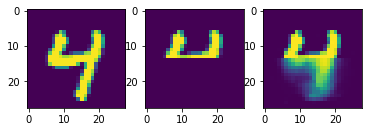

ValidEpoch  3: 100%|█████████████████████████████████████████████████████| 750/750 [00:57<00:00, 13.16it/s, loss=0.121]


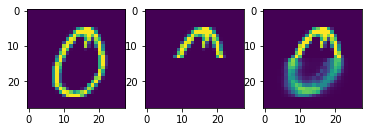

ValidEpoch  4: 100%|█████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.20it/s, loss=0.117]


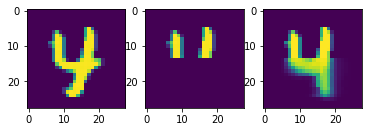

ValidEpoch  5: 100%|█████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.19it/s, loss=0.115]


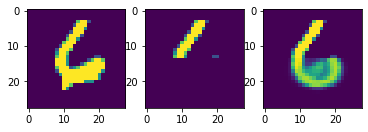

ValidEpoch  6: 100%|█████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.18it/s, loss=0.115]


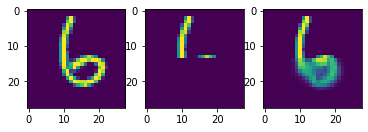

ValidEpoch  7: 100%|█████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.23it/s, loss=0.114]


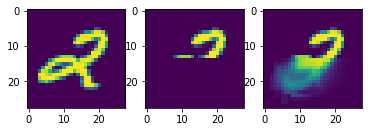

ValidEpoch  8: 100%|█████████████████████████████████████████████████████| 750/750 [00:57<00:00, 12.93it/s, loss=0.115]


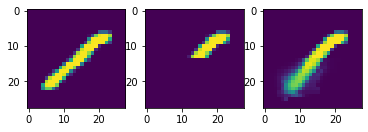

ValidEpoch  9: 100%|█████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.17it/s, loss=0.117]


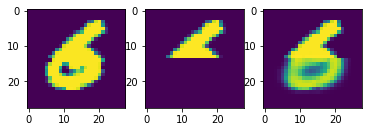

ValidEpoch 10: 100%|█████████████████████████████████████████████████████| 750/750 [00:56<00:00, 13.16it/s, loss=0.116]


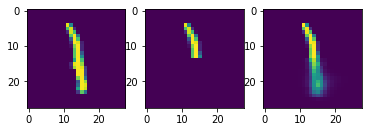

Early stopping!
Finished Training!


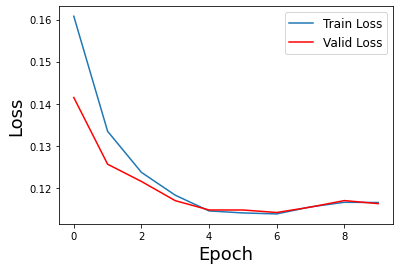

In [5]:

loss_meter = meter.AverageValueMeter()
loss_dic={'train_loss':[], 'valid_loss':[], 'lr':[]}


        
#early_stopping
patience=3
earlystop=0
best_loss=float('inf')

        
for epoch in range(20):
    #train
    model.train()
    loss_meter.reset()
    with  tqdm(train_loader) as tepoch:
        for inputs, labels in tepoch:
            tepoch.set_description(f'TrainEpoch{epoch+1:3d}')
            
            b, c, h, w=inputs.size()
            msk= torch.ones(inputs.size())
            msk[:,:,h//2:,:]=0
            
            src, tgt = inputs*msk, inputs
            src, tgt= src.view(b,-1,c).to(device),tgt.view(b,-1,c).to(device)
            
            out=model(src)
            
            optimizer.zero_grad()
            crit = criterion(out, tgt)
            loss_meter.add(crit.item())
            crit.backward()
            optimizer.step()
            tepoch.set_postfix({'loss':'{0:.3f}'.format(loss_meter.value()[0])})
    loss_dic['train_loss'].append(loss_meter.value()[0])
    scheduler.step()
    #valid
    model.eval()
    loss_meter.reset()
    with tqdm(valid_Loader) as tepoch:
        for inputs, labels in tepoch:
            tepoch.set_description(f'ValidEpoch{epoch+1:3d}')
            b, c, h, w=inputs.size()
            msk= torch.ones(inputs.size())
            msk[:,:,h//2:,:]=0
            
            src, tgt = inputs*msk, inputs
            src, tgt= src.view(b,-1,c).to(device),tgt.view(b,-1,c).to(device)
            
            out=model(src)
            
            crit = criterion(out, tgt)
            loss_meter.add(crit.item())
            
            tepoch.set_postfix({'loss':'{0:.3f}'.format(loss_meter.value()[0])})
    loss_dic['valid_loss'].append(loss_meter.value()[0])
    loss_dic['lr'].append(scheduler.get_last_lr())
            
            
    # Show progress
    f, ax = plt.subplots(1,3) 
    ax[0].imshow(torchvision.transforms.ToPILImage()(tgt[0].view(c, h, w))) 
    ax[1].imshow(torchvision.transforms.ToPILImage()(src[0].view(c, h, w))) 
    ax[2].imshow(torchvision.transforms.ToPILImage()(out[0].view(c, h, w))) 
    plt.show()
    
    # earlystopping
    cur_loss=loss_meter.value()[0]
    if cur_loss>best_loss:
        earlystop+=1
        if earlystop>= patience:
            print('Early stopping!')
            break
    else:
        earlystop=0
        best_loss=cur_loss
        torch.save(model.state_dict(), 'lin_best.pt')

print('Finished Training!')

#plot training loss and valid loss


plt.plot(loss_dic['train_loss'])
plt.plot(loss_dic['valid_loss'],color='r')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(["Train Loss", "Valid Loss"],fontsize=12)
plt.show()

In [5]:
#Load/store model
#torch.save(model.state_dict(), 'lin.pt')
model.load_state_dict(torch.load('lin.pt'))

<All keys matched successfully>

100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:47<00:00, 13.03it/s]


----------------------------------------------------PREDICT----------------------------------------------------


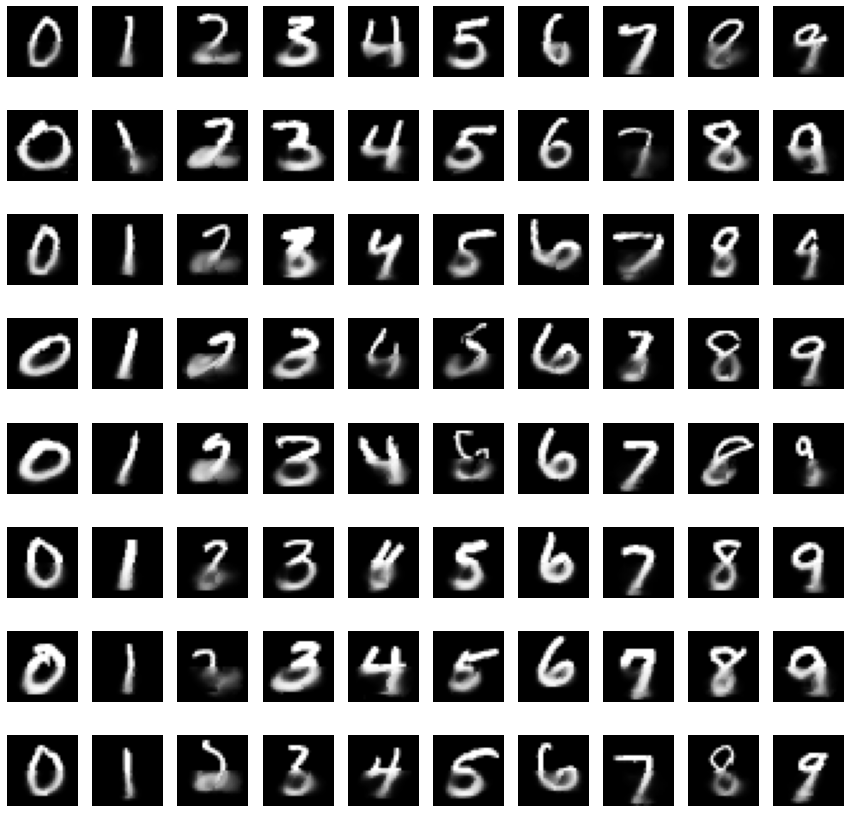

----------------------------------------------------TARGET----------------------------------------------------


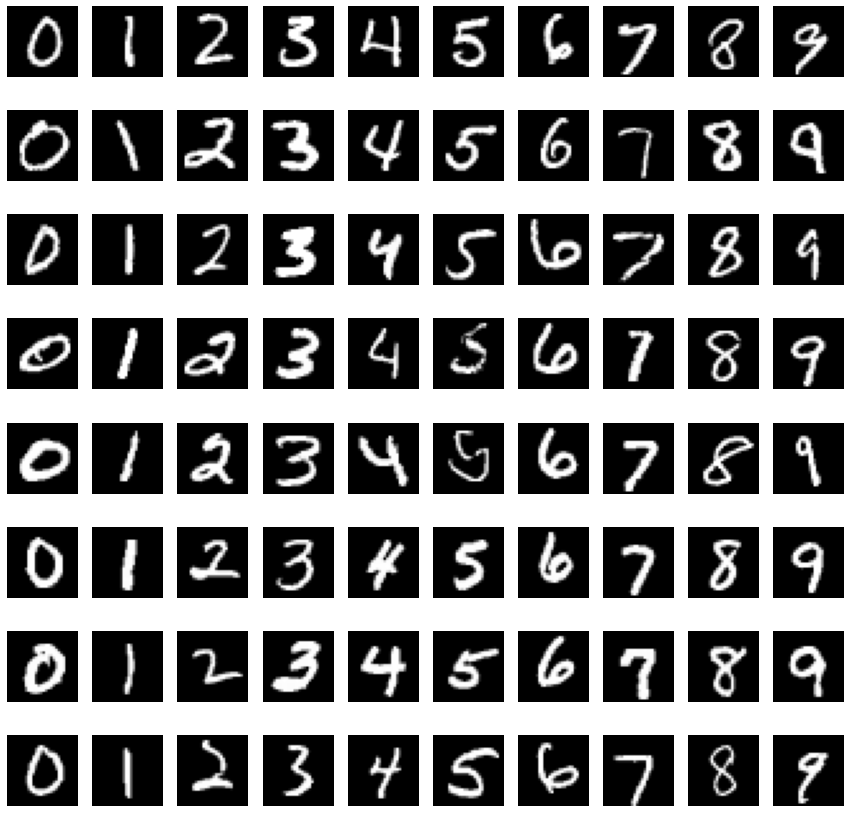

In [6]:
img_set={}
target_set={}
model.eval()
with tqdm(test_loader) as tepoch:
    for inputs ,label in tepoch:
        b, c, h, w=inputs.size()
        msk= torch.ones(inputs.size())
        msk[:,:,h//2:,:]=0
        src, tgt = inputs*msk, inputs
        src, tgt= src.view(b,-1,c).to(device),tgt.view(b,-1,c).to(device)
        out = model(src)
        for idx in range(len(label)):
            l=int(label[idx].cpu().detach().numpy())
            i=out[idx].view(1,28,28).cpu().detach()
            t=tgt[idx].view(1,28,28).cpu().detach()
            if l not in img_set:
                img_set[l]=[i]
                target_set[l]=[t]
            else:
                img_set[l].append(i)
                target_set[l].append(t)

print('-'*52+'PREDICT'+'-'*52)
f, ax = plt.subplots(8,10,figsize=(15,15))
for i in range(10):
    for j in range(8):
        ax[j][i].imshow(transforms.ToPILImage()(img_set[i][j]),cmap='gray')
        ax[j][i].axis('off')
plt.show()
print('-'*52+'TARGET'+'-'*52)
f, ax = plt.subplots(8,10,figsize=(15,15))
for i in range(10):
    for j in range(8):
        ax[j][i].imshow(transforms.ToPILImage()(target_set[i][j]),cmap='gray')
        ax[j][i].axis('off')
plt.show()